# OpenHAP chamber test

## Import required libraries

In [43]:
import csv
import time
import datetime
import paho.mqtt.client as mqtt

## Setup defaults

In [44]:
broker_address = "127.0.0.1"

In [45]:
time_field_txt = "Message received time"
device_field_txt = "Device"
device_time_field_txt = "Device Time"
measurement_field_txt = "Particulate measurement"
csv_fieldnames = [time_field_txt, device_field_txt, device_time_field_txt, measurement_field_txt]

In [46]:
csv_file = "chamberTest.csv"
broker_state_file = "broker.csv"

## Set dynamic plotting function

In [52]:
import pandas as pd
from IPython.display import clear_output
from matplotlib import pyplot as plt

%matplotlib inline

def live_plot():
    df = pd.read_csv(csv_file)
    df[device_time_field_txt] = pd.to_datetime(df[device_time_field_txt],unit='s')
    df[measurement_field_txt]= df[measurement_field_txt].astype(int)
    df.set_index(device_time_field_txt, inplace=True)
    df.groupby(device_field_txt)[measurement_field_txt].plot(legend=True, figsize=(20,10), grid=True)
    clear_output(wait=True)
    plt.show();

## Setup event callbacks

In [48]:
def on_connect(client, userdata, flags, rc):
    if rc == 0:
        print("Connected OK Returned code=",rc)
        system_mid = client.subscribe("$SYS/broker/clients/#")[-1]
        command_mid = client.subscribe("command")[-1]
        measurement_mid = client.subscribe("measurement/#")[-1]

In [48]:
command_mid = 0
measurement_mid = 0
system_mid = 0 

In [49]:
def on_subscribe(client, userdata, mid, granted_qos):       
    if mid == measurement_mid:
        print("measurement topics successfully subscribed")
    elif mid == command_mid:
        print("Command topic successfully subscribed")
    elif mid == system_mid:
        print("System topic successfully subscribed")
    else:
        print("Other topic subscription acknowledgement received")

In [50]:
def on_message(client, userdata, message):
    if message.topic == "command":
        print("Measurement command sent!")
    if "measurement" in message.topic:
            mqtt_topic_levels = message.topic.split('/')
            if len(mqtt_topic_levels) != 2:
                print("Improperly formatted measurement topic received")
            else:
                message_received_time = datetime.datetime.now()
                device = mqtt_topic_levels[1]
                
                payload = str(message.payload, 'utf-8').split(',')
                measurement = int(payload[0])
                device_time = int(payload[1])
                
                with open(csv_file, 'a') as measurement_file:
                    print("CSV file opened - writing header")
                    writer = csv.DictWriter(measurement_file, fieldnames=csv_fieldnames)
                    writer.writerow({time_field_txt: message_received_time,
                                     device_time_field_txt : device_time,
                                     device_field_txt: device,
                                     measurement_field_txt:measurement})
                    measurement_file.close()
                live_plot()

## Test code

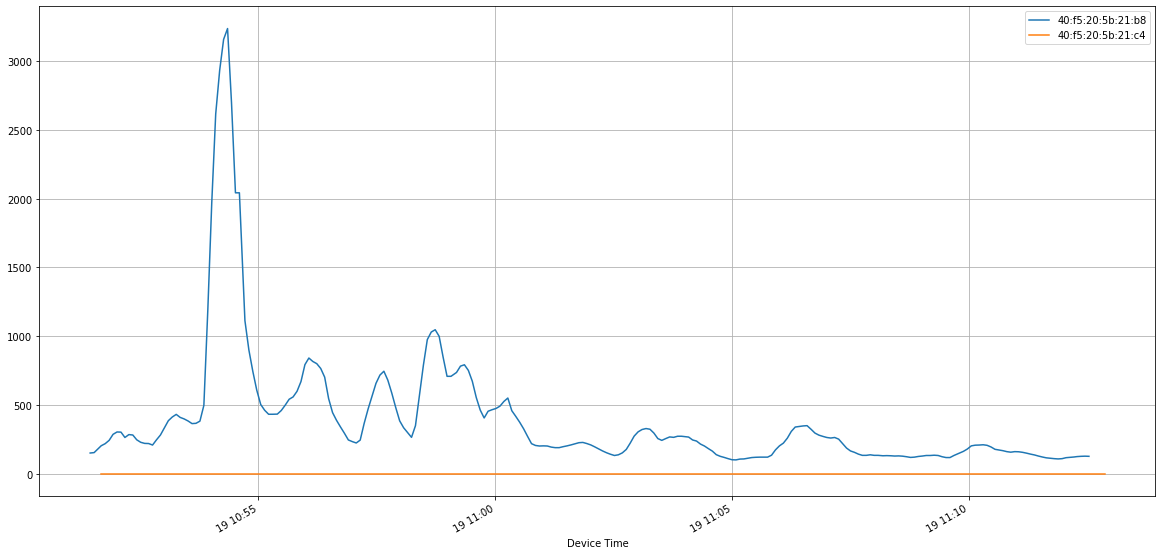

Measurement command sent!
CSV file closed and event loop thread stopped
End of program


In [55]:
controller = mqtt.Client("controller",clean_session=True)

controller.on_connect = on_connect
controller.on_subscribe = on_subscribe
controller.on_message = on_message

with open(csv_file, 'w') as measurement_file:
    print("CSV file opened - writing header")
    writer = csv.DictWriter(measurement_file, fieldnames=csv_fieldnames)
    writer.writeheader()
    measurement_file.close()
    
controller.connect(broker_address)
controller.loop_start()

while True:
    try:
        time.sleep(5)
        controller.publish("command", "measure")
    except KeyboardInterrupt:
        controller.loop_stop()
        controller.disconnect()
        print("CSV file closed and event loop thread stopped")
        break
print("End of program")